# NASA Exoplanet Mass Prediction

This notebook predict Mass of a exoplanet using NASA Exoplanet Archive data

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro, chi2_contingency
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
import itertools
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Inspection

In [2]:
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Data Types:")
print(df.dtypes.value_counts())

target_col = 'pl_bmasse'
print(f"\nTarget variable '{target_col}' statistics:")
print(df[target_col].describe())

Dataset shape: (38898, 354)
Memory usage: 291.88 MB

Column Data Types:
float64    239
object      89
int64       26
Name: count, dtype: int64

Target variable 'pl_bmasse' statistics:
count     6866.000000
mean       710.053607
std       1451.794928
min          0.015000
25%         13.300000
50%        190.000000
75%        664.979818
max      25426.400000
Name: pl_bmasse, dtype: float64


# Data Quality Assessment and Missing Value Analysis

In [3]:
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

relevant_features = ['pl_bmasse', 'pl_rade', 'pl_orbper', 'pl_orbsmax', 'pl_eqt',
                    'st_mass', 'st_rad', 'st_teff', 'st_met', 'st_age', 'st_dens',
                    'pl_dens', 'discoverymethod', 'disc_year', 'sy_dist']

df_filtered = df[relevant_features].copy()

df_clean = df_filtered.dropna(subset=[target_col])

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

for col in numeric_cols:
    if col != target_col:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

for col in categorical_cols:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

Clean dataset shape: (6866, 15)
Remaining missing values: 0


# Exploratory Data Analysis

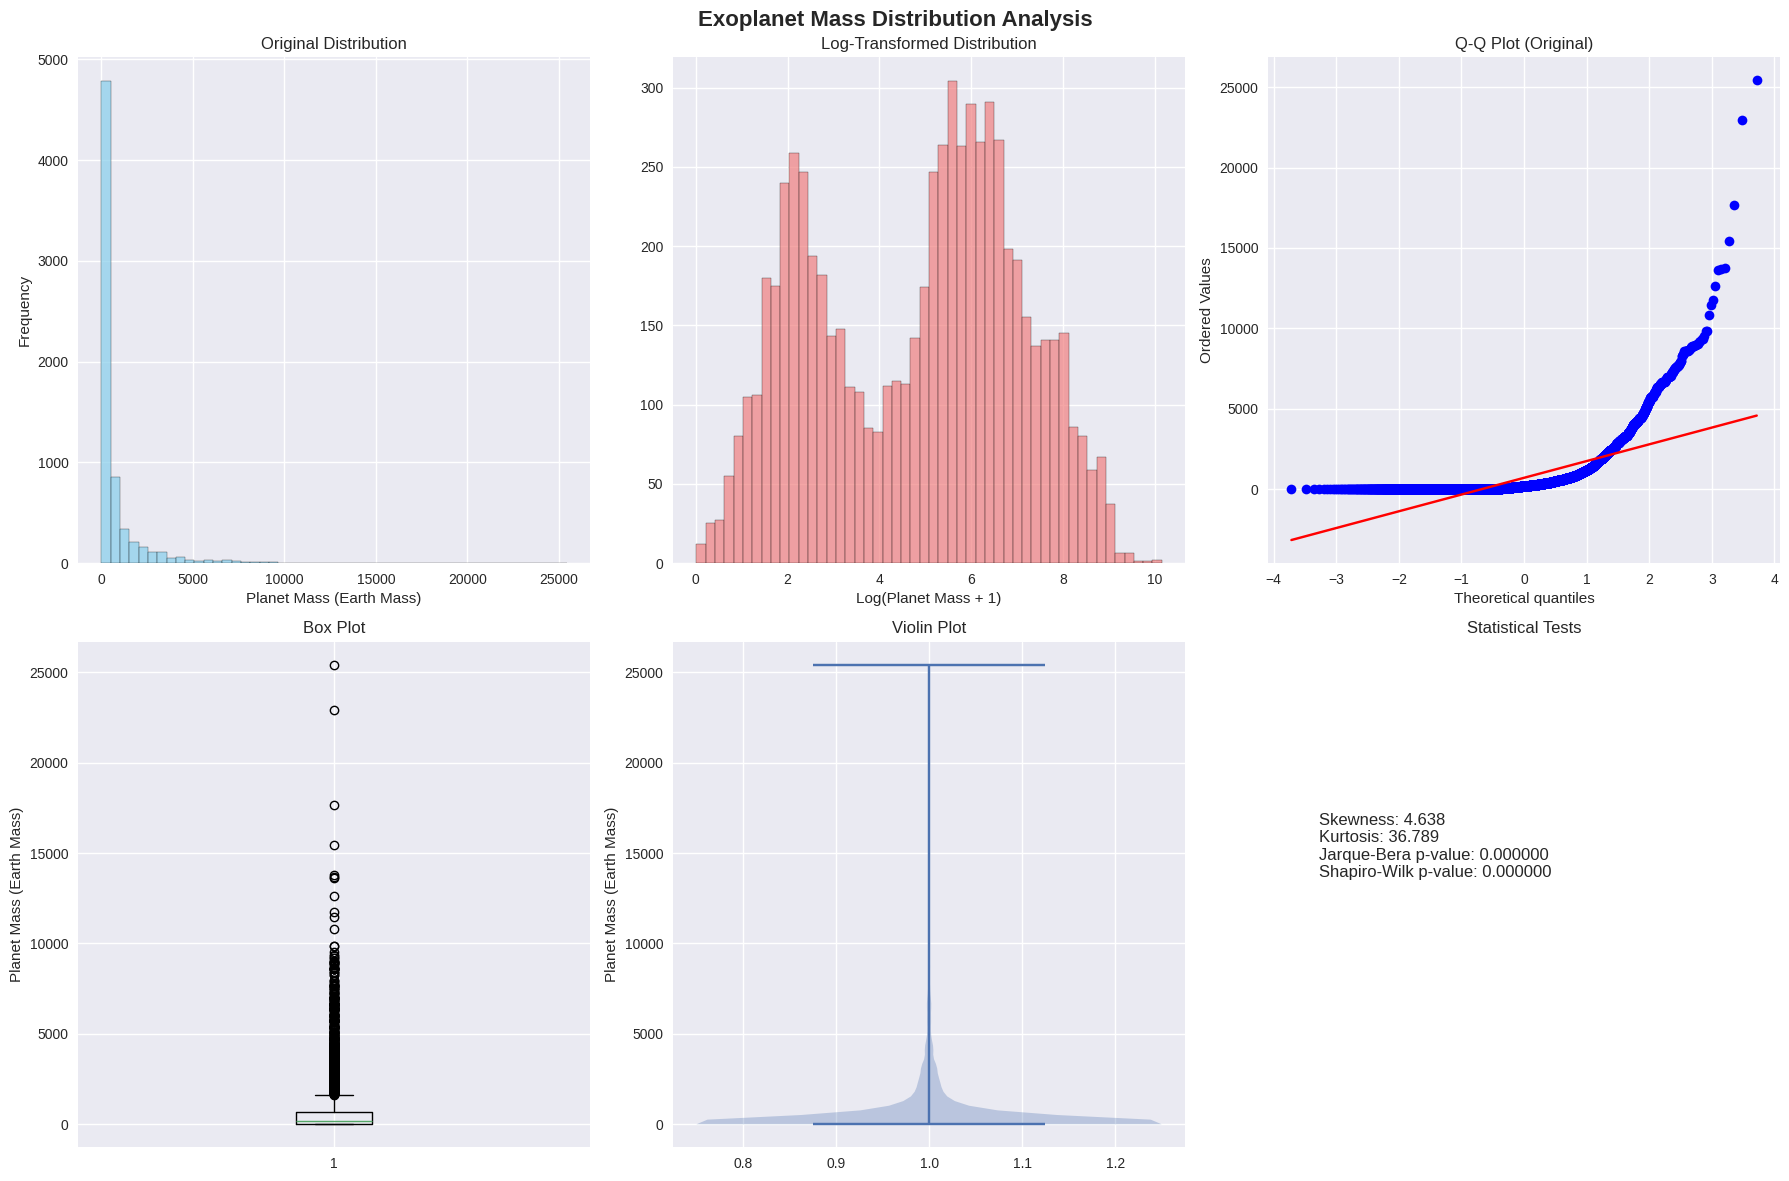

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exoplanet Mass Distribution Analysis', fontsize=16, fontweight='bold')

axes[0,0].hist(df_clean[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Original Distribution')
axes[0,0].set_xlabel('Planet Mass (Earth Mass)')
axes[0,0].set_ylabel('Frequency')

log_target = np.log1p(df_clean[target_col])
axes[0,1].hist(log_target, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Log-Transformed Distribution')
axes[0,1].set_xlabel('Log(Planet Mass + 1)')

stats.probplot(df_clean[target_col], dist="norm", plot=axes[0,2])
axes[0,2].set_title('Q-Q Plot (Original)')

axes[1,0].boxplot(df_clean[target_col])
axes[1,0].set_title('Box Plot')
axes[1,0].set_ylabel('Planet Mass (Earth Mass)')

axes[1,1].violinplot(df_clean[target_col])
axes[1,1].set_title('Violin Plot')
axes[1,1].set_ylabel('Planet Mass (Earth Mass)')

stats_text = f"""
Skewness: {stats.skew(df_clean[target_col]):.3f}
Kurtosis: {stats.kurtosis(df_clean[target_col]):.3f}
Jarque-Bera p-value: {jarque_bera(df_clean[target_col])[1]:.6f}
Shapiro-Wilk p-value: {shapiro(df_clean[target_col])[1]:.6f}
"""
axes[1,2].text(0.1, 0.5, stats_text, fontsize=12, transform=axes[1,2].transAxes)
axes[1,2].set_title('Statistical Tests')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

# Correlation Analysis and Feature Relationships

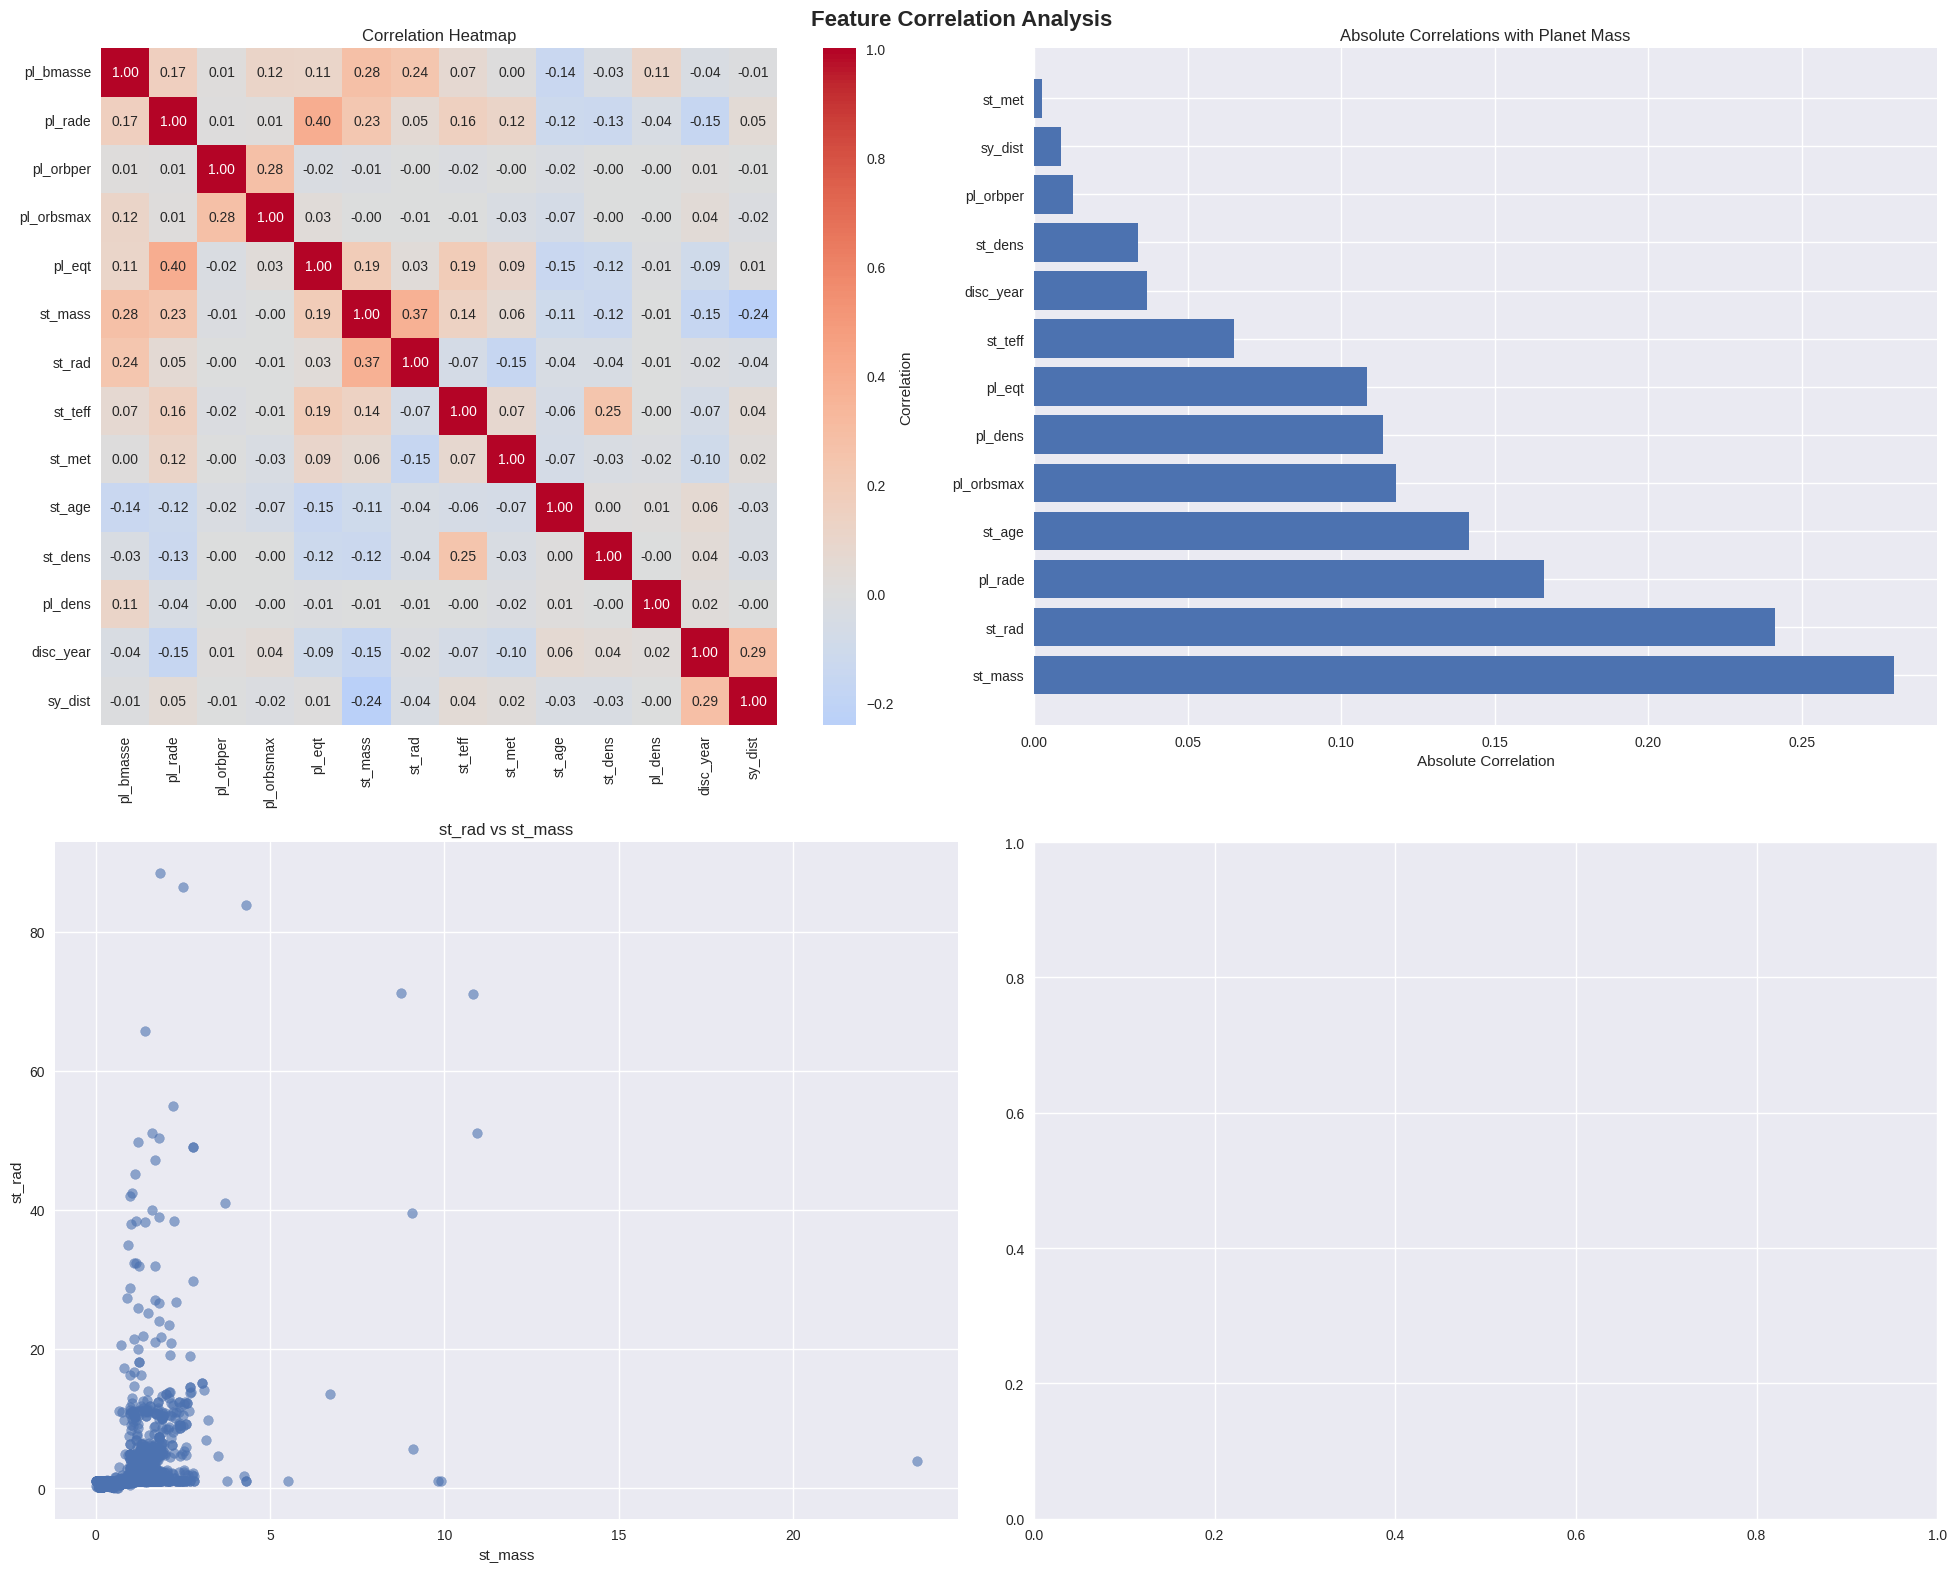

Top 5 features correlated with Planet Mass:
1. st_mass: 0.280
2. st_rad: 0.241
3. pl_rade: 0.166
4. st_age: 0.142
5. pl_orbsmax: 0.118


In [5]:
numeric_df = df_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[0,0], fmt='.2f', cbar_kws={'label': 'Correlation'})
axes[0,0].set_title('Correlation Heatmap')

target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)[1:]
axes[0,1].barh(range(len(target_corr)), target_corr.values)
axes[0,1].set_yticks(range(len(target_corr)))
axes[0,1].set_yticklabels(target_corr.index)
axes[0,1].set_title('Absolute Correlations with Planet Mass')
axes[0,1].set_xlabel('Absolute Correlation')

top_features = target_corr.head(4).index.tolist() + [target_col]
scatter_data = df_clean[top_features]

for i, feat1 in enumerate(top_features[:-1]):
    for j, feat2 in enumerate(top_features[:-1]):
        if i == j:
            continue
        if i < 2 and j < 2:
            row, col = i, j if j < i else j + 1
            if col < 2:
                axes[1, col].scatter(scatter_data[feat2], scatter_data[feat1], alpha=0.6)
                axes[1, col].set_xlabel(feat2)
                axes[1, col].set_ylabel(feat1)
                axes[1, col].set_title(f'{feat1} vs {feat2}')

plt.tight_layout()
plt.show()

print("Top 5 features correlated with Planet Mass:")
for i, (feature, corr) in enumerate(target_corr.head(5).items()):
    print(f"{i+1}. {feature}: {corr:.3f}")

# Categorical Feature Analysis

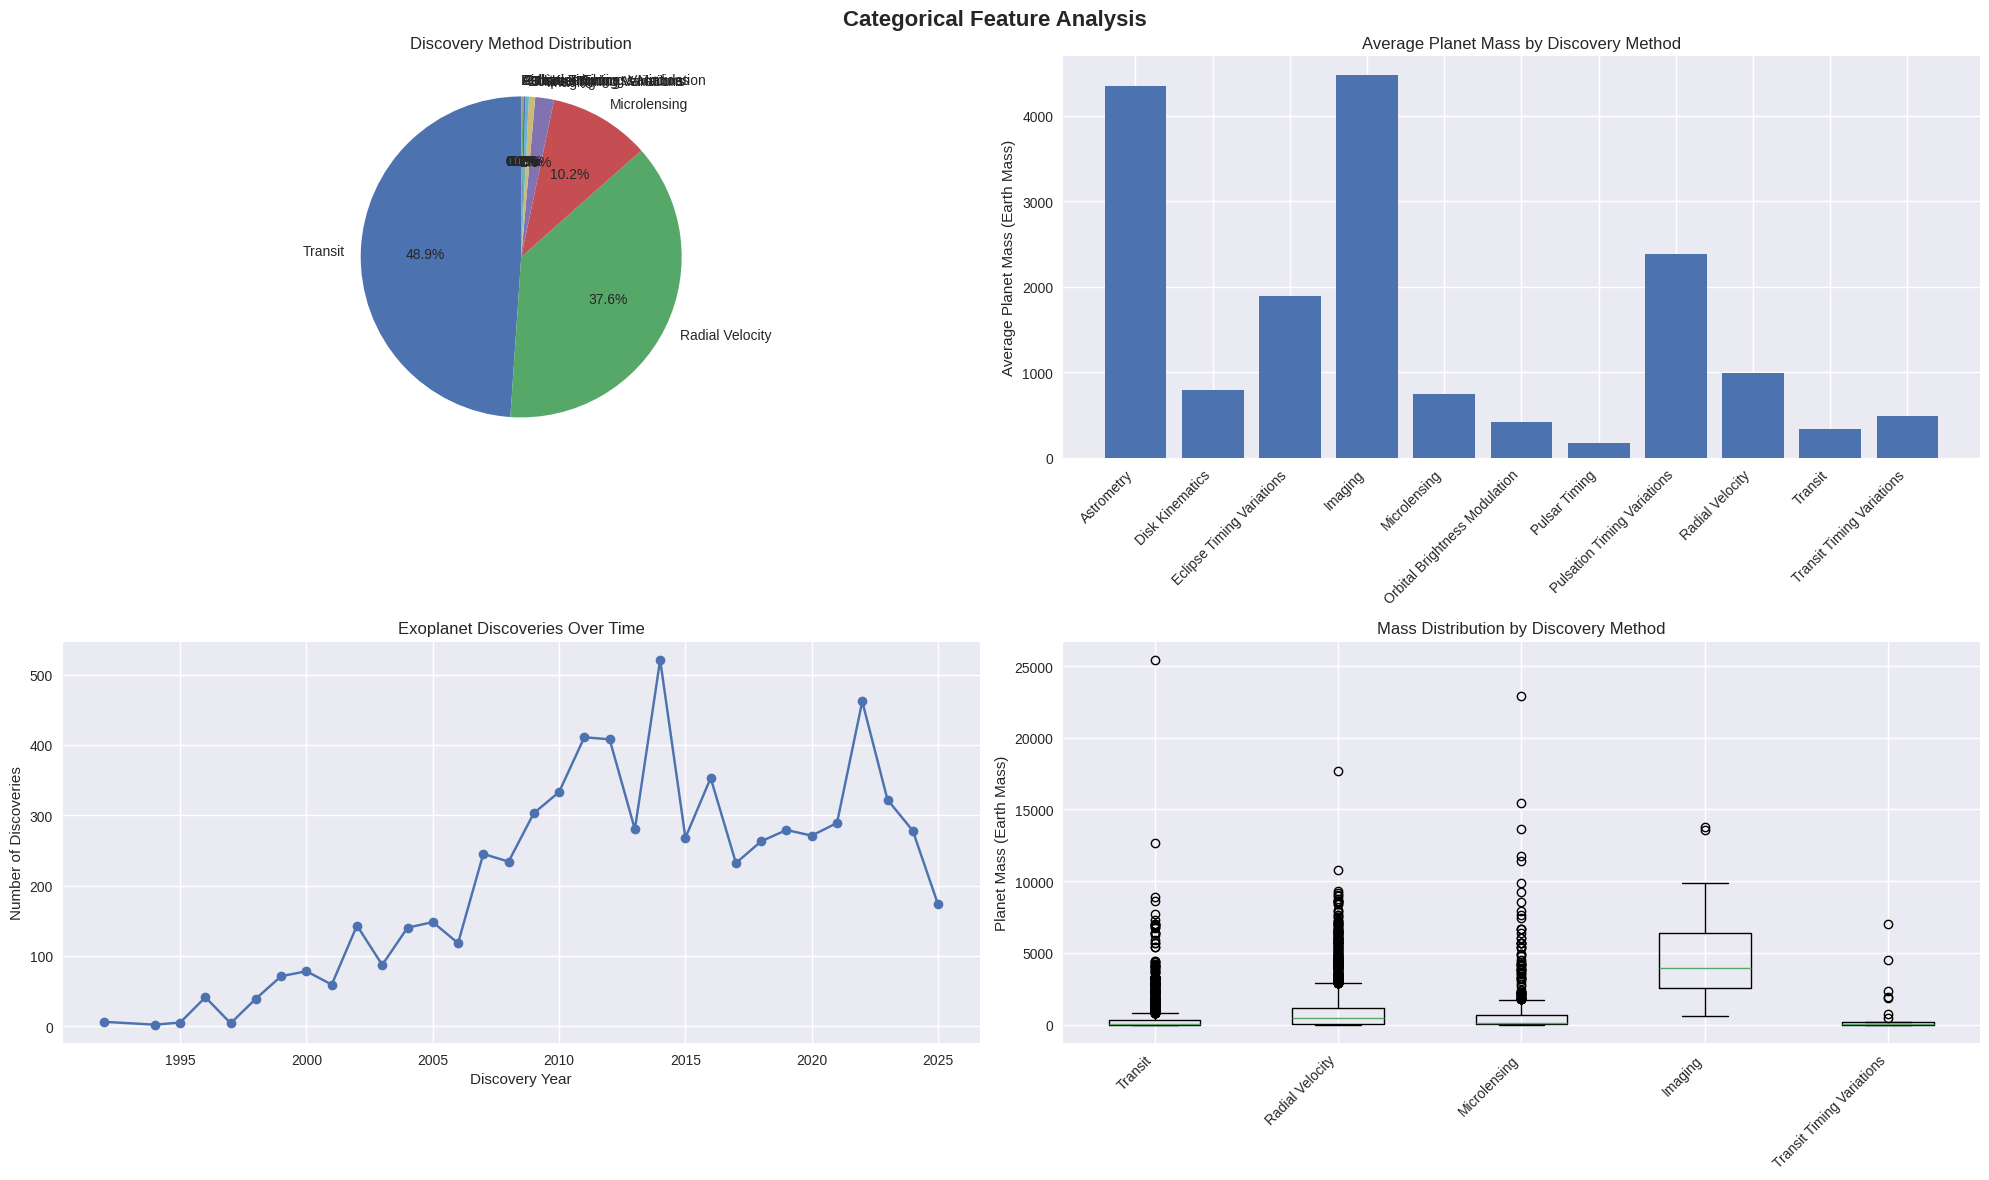

ANOVA F-statistic: 363.508, p-value: 0.000000


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Categorical Feature Analysis', fontsize=16, fontweight='bold')

discovery_counts = df_clean['discoverymethod'].value_counts()
axes[0,0].pie(discovery_counts.values, labels=discovery_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Discovery Method Distribution')

discovery_mass = df_clean.groupby('discoverymethod')[target_col].agg(['mean', 'median', 'std', 'count'])
axes[0,1].bar(range(len(discovery_mass)), discovery_mass['mean'])
axes[0,1].set_xticks(range(len(discovery_mass)))
axes[0,1].set_xticklabels(discovery_mass.index, rotation=45, ha='right')
axes[0,1].set_title('Average Planet Mass by Discovery Method')
axes[0,1].set_ylabel('Average Planet Mass (Earth Mass)')

yearly_discovery = df_clean['disc_year'].value_counts().sort_index()
axes[1,0].plot(yearly_discovery.index, yearly_discovery.values, marker='o')
axes[1,0].set_title('Exoplanet Discoveries Over Time')
axes[1,0].set_xlabel('Discovery Year')
axes[1,0].set_ylabel('Number of Discoveries')

discovery_methods = df_clean['discoverymethod'].value_counts().head(5).index
filtered_data = df_clean[df_clean['discoverymethod'].isin(discovery_methods)]
box_data = [filtered_data[filtered_data['discoverymethod'] == method][target_col].values
            for method in discovery_methods]
axes[1,1].boxplot(box_data, labels=discovery_methods)
axes[1,1].set_xticklabels(discovery_methods, rotation=45, ha='right')
axes[1,1].set_title('Mass Distribution by Discovery Method')
axes[1,1].set_ylabel('Planet Mass (Earth Mass)')

plt.tight_layout()
plt.show()

f_stat, p_value = stats.f_oneway(*box_data)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.6f}")

# Advanced Feature Engineering

In [7]:
df_engineered = df_clean.copy()

df_engineered['mass_radius_ratio'] = df_engineered['pl_bmasse'] / (df_engineered['pl_rade'] ** 3)
df_engineered['stellar_planet_mass_ratio'] = df_engineered['st_mass'] / df_engineered['pl_bmasse']
df_engineered['orbital_velocity'] = np.sqrt(df_engineered['st_mass'] / df_engineered['pl_orbsmax'])
df_engineered['escape_velocity'] = np.sqrt(2 * df_engineered['pl_bmasse'] / df_engineered['pl_rade'])
df_engineered['hill_sphere'] = df_engineered['pl_orbsmax'] * (df_engineered['pl_bmasse'] / (3 * df_engineered['st_mass'])) ** (1/3)

df_engineered['stellar_age_category'] = pd.cut(df_engineered['st_age'],
                                              bins=[0, 1, 5, 10, float('inf')],
                                              labels=['Young', 'Mature', 'Old', 'Ancient'])

df_engineered['planet_star_temp_ratio'] = df_engineered['pl_eqt'] / df_engineered['st_teff']

df_engineered['distance_category'] = pd.cut(df_engineered['sy_dist'],
                                           bins=[0, 100, 500, 1000, float('inf')],
                                           labels=['Near', 'Intermediate', 'Far', 'Very_Far'])

df_engineered['log_orbital_period'] = np.log1p(df_engineered['pl_orbper'])
df_engineered['sqrt_orbital_distance'] = np.sqrt(df_engineered['pl_orbsmax'])

df_engineered['mass_temp_interaction'] = df_engineered['st_mass'] * df_engineered['pl_eqt']
df_engineered['radius_period_interaction'] = df_engineered['pl_rade'] * df_engineered['pl_orbper']
df_engineered['stellar_mass_metallicity'] = df_engineered['st_mass'] * df_engineered['st_met']

poly_features = ['pl_rade', 'st_mass', 'pl_orbper']
for feature in poly_features:
    df_engineered[f'{feature}_squared'] = df_engineered[feature] ** 2
    df_engineered[f'{feature}_cubed'] = df_engineered[feature] ** 3

df_engineered['density_ratio'] = df_engineered['pl_dens'] / df_engineered['st_dens']
df_engineered['log_planet_density'] = np.log1p(df_engineered['pl_dens'])

print(f"Original features: {df_clean.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print(f"New features added: {df_engineered.shape[1] - df_clean.shape[1]}")

Original features: 15
Engineered features: 36
New features added: 21
